# Import necessary libraries

In [1]:
from saltup.ai.classification.datagenerator import ClassificationDataloader, keras_ClassificationDataGenerator
from saltup.ai.base_dataformat.base_datagen import *
from saltup.ai.training.app_callbacks import ClassificationEvaluationsCallback
from saltup.ai.classification.evaluate import evaluate_model
from saltup.utils.jupyter_notebook import generate_notebook_id, save_current_notebook
from saltup.ai.training.train import training
from saltup.utils.data.image.image_utils import Image, ColorMode


import os
import zipfile
import numpy as np
from glob import glob
from datetime import datetime
import tensorflow as tf

2025-09-05 15:48:44.349492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-05 15:48:44.361782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757080124.376121 1433947 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757080124.379915 1433947 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-05 15:48:44.394717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Download the Dataset

In [ ]:

#download the dataset
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O cats_and_dogs.zip


# Unzip the file using Python
with zipfile.ZipFile("cats_and_dogs.zip", "r") as zip_ref:
    extract_dir = "dataset"
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
    zip_ref.extractall(extract_dir)
    
    os.remove("cats_and_dogs.zip")

# Define constants

In [2]:
NUM_CLASSES = 2
BATCH_SIZE = 32
EPOCHS = 3
CALLBACK_EPOCH = 3  # Test the model every CALLBACK_EPOCH epochs
INPUT_SIZE = (128, 128)
TRAIN_DATA_DIR = './dataset/cats_and_dogs_filtered/train'
TEST_DATA_DIR = './dataset/cats_and_dogs_filtered/validation'
CLASS_NAMES = ['cats', 'dogs']
CLASS_DICTIONARY = {'cats': 0, 'dogs': 1}

# Load a pre-trained model or define your own architecture

In [3]:
import tensorflow as tf
import keras
#Define the model architecture

def build_model(input_shape=(128, 128, 3), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Conv2D(8, (3, 3), activation='relu')(inputs)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

model = build_model(input_shape=(128, 128, 3), num_classes=NUM_CLASSES)


2025-09-05 15:48:53.872229: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Data generator

In [4]:
#Define the preprocessing function

def preprocess(image:np.ndarray, target_size:tuple) -> np.ndarray:
    """Preprocess the image by resizing and normalizing."""
    temp_image = Image(image)
    temp_image = temp_image.resize(target_size)
    img = temp_image.get_data()
    img = img / 255.0  # Normalize pixel values between [0, 1]
    return img

In [5]:
#Define the augmentation transformations

transformed_img = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5)
   ])

In [6]:
#Create the data loaders

train_dataloader = ClassificationDataloader(
    source=TRAIN_DATA_DIR,
    classes_dict=CLASS_DICTIONARY,
    img_size=(224, 224, 3)
)

test_dataloader = ClassificationDataloader(
    source=TEST_DATA_DIR,
    classes_dict=CLASS_DICTIONARY,
    img_size=(224, 224, 3)
)

In [7]:

# Create Classification Data Generator

train_gen = keras_ClassificationDataGenerator(
    dataloader=train_dataloader,
    target_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    preprocess=preprocess,
    transform=transformed_img
)


test_gen = keras_ClassificationDataGenerator(
    dataloader=test_dataloader,
    target_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    preprocess=preprocess,
    transform=None  # no augmentation
)

images, labels = next(iter(train_gen))
print(images.shape)
print(labels.shape)

(32, 128, 128, 3)
(32, 2)


Example image shape: 63
0.996078431372549


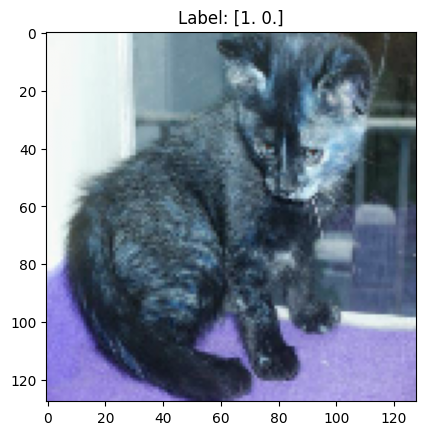

In [8]:
#Plot an example image

example_image = train_gen[0][0][9]
example_label = train_gen[0][1][9]
print(f"Example image shape: {len(train_gen)}")
#plot image
import matplotlib.pyplot as plt
def plot_image(image, label):
    plt.imshow(image.squeeze())
    plt.title(f"Label: {label}")
    #plt.axis('off')
    plt.show()
   
print(np.max(example_image))
plot_image(example_image, example_label)

# Training

In [9]:
#Define the output directory and create it if it doesn't exist
todaytime = datetime.now()
output_dir = "./training_outputs"
current_tests_folder_name = "train_{}".format(todaytime.strftime("%d-%m-%Y_%H-%M-%S"))
current_output_dir = os.path.join(output_dir, current_tests_folder_name)
if not os.path.exists(current_output_dir):
    os.makedirs(current_output_dir)
    
#Define the custom callback for classification evaluations
custom_cb = ClassificationEvaluationsCallback(
    datagen=test_gen,                # used for evaluation during training for every CALLBACK_EPOCH
    end_of_train_datagen=test_gen,   #called at the end of training
    every_epoch=CALLBACK_EPOCH,
    output_file=os.path.join(current_output_dir, "classification_evaluations.txt"),
    class_names=CLASS_NAMES

)

In [10]:
# Define model compilation parameters
initial_learning_rate = 0.001
decay_steps = 1000
keras_optimizer =  tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps))
keras_loss = tf.keras.losses.CategoricalCrossentropy()

# Define k-fold parameters
# This is set to False for simplicity, but can be enabled for k-fold cross-validation
# If enabled, the split parameter defines the proportion of data in each fold
kfold_parameters = {'enable':False, 'split':[0.2, 0.2, 0.2, 0.2, 0.2]}

# Define the model output name
model_output_name = "tiny_model"

# Start the training process
results_dict = training(
        train_gen,
        model=model,
        loss_function=keras_loss,
        optimizer=keras_optimizer,
        epochs=EPOCHS,
        output_dir=current_output_dir,
        validation_split=[0.2, 0.8],
        kfold_param =kfold_parameters,
        model_output_name = model_output_name,
        training_callback=[custom_cb])


--- Model training ---


/home/mark/anaconda3/envs/saltup/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.6958 - val_loss: 0.6792
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.6657 - val_loss: 0.6908
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.6170


                          METRICS SUMMARY FOR EPOCH 3                           
Best model epoch: 3 | Best loss: 0.6023 | Best val_loss: 0.6667
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:02<00:00, 11.18it/s, accuracy=0.445, fn=384, fp=384, tp=616]


Images processed:    1000

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.3118    
dogs               | 0.5351    

Overall:
True Positives (TP):      616
False Positives (FP):     384
Overall Accuracy:         0.4451
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - loss: 0.6167 - val_loss: 0.6667



                              METRICS ON TRAIN END                              
class_names: ['cats', 'dogs']


Processing data: 100%|██████████| 32/32 [00:02<00:00, 10.92it/s, accuracy=0.445, fn=384, fp=384, tp=616]


Images processed:    32

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.3118    
dogs               | 0.5351    

Overall:
True Positives (TP):      616
False Positives (FP):     384
Overall Accuracy:         0.4451
Saved trained model at ./training_outputs/train_05-09-2025_15-48-54/saved_models/tiny_model_best.keras 
[2025-09-05 15:49:17] - tf2onnx.tfonnx - INFO - Using tensorflow=2.18.0, onnx=1.17.0, tf2onnx=1.16.1/15c810
[2025-09-05 15:49:17] - tf2onnx.tfonnx - INFO - Using opset <onnx, 15>
[2025-09-05 15:49:17] - tf2onnx.tf_utils - INFO - Computed 0 values for constant folding
[2025-09-05 15:49:17] - tf2onnx.optimizer - INFO - Optimizing ONNX model


I0000 00:00:1757080157.195549 1433947 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1757080157.195663 1433947 single_machine.cc:361] Starting new session
I0000 00:00:1757080157.297314 1433947 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1757080157.297451 1433947 single_machine.cc:361] Starting new session


[2025-09-05 15:49:17] - tf2onnx.optimizer - INFO - After optimization: Cast -1 (1->0), Identity -2 (2->0), Transpose -6 (8->2)
[2025-09-05 15:49:17] - absl - INFO - Function `function` contains input name(s) resource with unsupported characters which will be renamed to functional_1_dense_1_2_biasadd_readvariableop_resource in the SavedModel.
[2025-09-05 15:49:17] - absl - INFO - Function `function` contains input name(s) resource with unsupported characters which will be renamed to functional_1_dense_1_2_biasadd_readvariableop_resource in the SavedModel.
INFO:tensorflow:Assets written to: /tmp/tmpza56tud2/assets
[2025-09-05 15:49:17] - tensorflow - INFO - Assets written to: /tmp/tmpza56tud2/assets
Saved artifact at '/tmp/tmpza56tud2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  14020900

W0000 00:00:1757080158.044837 1433947 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1757080158.044855 1433947 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-09-05 15:49:18.045092: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpza56tud2
2025-09-05 15:49:18.045542: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-05 15:49:18.045554: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpza56tud2
I0000 00:00:1757080158.048282 1433947 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-09-05 15:49:18.048863: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-05 15:49:18.078335: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpza56tud2
2025-09-05 15:49:18.084906: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

# Inference on test dataset

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Processing data:   0%|          | 0/32 [00:00<?, ?it/s]

Processing data: 100%|██████████| 32/32 [00:01<00:00, 22.37it/s, accuracy=0.445, fn=384, fp=384, tp=616]


Confusion matrix saved at ./training_outputs/train_05-09-2025_15-48-54/tflite_model_confusion_matrix.png


<Figure size 1000x700 with 0 Axes>

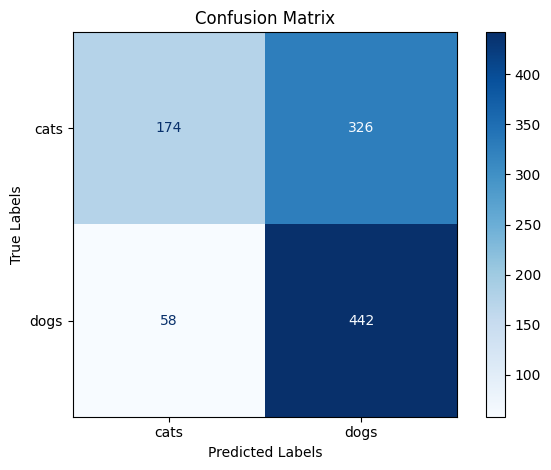

Global metrics:
FP: 384
FN: 384
Accuracy: 0.4451

Per-class metrics:
Class: cats
  FP: 58
  FN: 326
  Accuracy: 0.3118
Class: dogs
  FP: 326
  FN: 58
  Accuracy: 0.5351


In [ ]:
# Check the results and evaluate the model
model_path = [res for res in results_dict['models_paths'] if res.endswith('.keras')][0]


global_metric, metric_per_class = evaluate_model(
    model_path, 
    test_gen=test_gen,
    output_dir=current_output_dir,
    conf_matrix=True
)

# Print the evaluation results
print("Global metrics:")
print("FP:", global_metric.getFP())
print("FN:", global_metric.getFN())
print("Accuracy:", f"{global_metric.getAccuracy():.4f}")

print("\nPer-class metrics:")
for idx, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print("  FP:", metric_per_class[idx].getFP())
    print("  FN:", metric_per_class[idx].getFN())
    print("  Accuracy:", f"{metric_per_class[idx].getAccuracy():.4f}")

In [ ]:
from saltup.ai.utils.keras.quantization import quantize

model_path = [res for res in results_dict['models_paths'] if res.endswith('.keras')][0]
model_folder = os.path.dirname(model_path)
quantized_model_path = os.path.join(model_folder, "quantize", f"{model_output_name}_quantized.tflite")

def representative_data_gen_fnct(datagenerator):
    for i in range(len(datagenerator)):
        images, _ = datagenerator[i]
        # If batch, yield each image separately for calibration
        if images.ndim == 4:
            for img in images:
                yield [img.astype(np.float32).reshape(1, *img.shape)]
        else:
            yield [images.astype(np.float32).reshape(1, *images.shape)]

# Pass the generator function itself, not its call
representative_data_gen = lambda: representative_data_gen_fnct(train_gen)
        
# Quantize the model
quantized_model_path = quantize(model_path, quantized_model_path, 
                           representative_data_gen, 
                           input_type = tf.uint8, 
                           output_type = tf.uint8)

# Evaluate the quantized model
global_metric, metric_per_class = evaluate_model(
    quantized_model_path, 
    test_gen=test_gen,
    output_dir=current_output_dir,
    conf_matrix=True
)

# Print the evaluation results
print("Global metrics:")
print("FP:", global_metric.getFP())
print("FN:", global_metric.getFN())
print("Accuracy:", f"{global_metric.getAccuracy():.4f}")

print("\nPer-class metrics:")
for idx, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print("  FP:", metric_per_class[idx].getFP())
    print("  FN:", metric_per_class[idx].getFN())
    print("  Accuracy:", f"{metric_per_class[idx].getAccuracy():.4f}")

In [ ]:
# Save the current notebook with the results. This is done at the end to ensure all outputs are captured.
save_current_notebook(current_output_dir)